In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import jax
import pytensor

In [7]:
np.set_printoptions(suppress=True)
RNG = np.random.default_rng(seed=2025)

jax.config.update("jax_enable_x64", False)
pytensor.config.floatX = "float32"

In [8]:
import hssm

# Introduction to the HSSM Toolbox

**Behavioral Data Science, Spring 2025**

In this notebook, we introduce the basic usage of the [HSSM](https://lnccbrown.github.io/HSSM/) (Hierarchical Sequential Sampling Modeling) toolbox for studying decision-making processes using a broad class of drift-diffusion models (DDM). 

## Review: Drift-Diffusion Model

As we have learned in class over the past two weeks, drift-diffusion models (DDMs) are a broad class of choice-decision models, with the decision-making process represented as a stochastic differential equations.

The model is governed by four key parameters:

1. **Drift rate** ($v$): speed of decision-making
2. **Decision boundary** ($a$): threshold of choice-alternative separation
3. **Starting point** ($b$, or $z$): initial conditions of decision-making (or, an *a priori* decision bias)
4. **Non-decision time** ($\tau$): the time delay for the decision-making process to start

In [ ]:
# Create a dictionary that stores the parameters
### Our code here
true_params = None

The [`ssms`](https://github.com/lnccbrown/ssm-simulators) (Sequential Sampling Modeling Simulators) package is used under the hood to simulate the data.

In [12]:
dataset = hssm.simulate_data(model="ddm", theta=true_params, size=1000)

In [39]:
type(dataset)

pandas.core.frame.DataFrame

In [40]:
dataset.shape

(1000, 2)

Text(0.5, 0, 'Reaction Time (sec)')

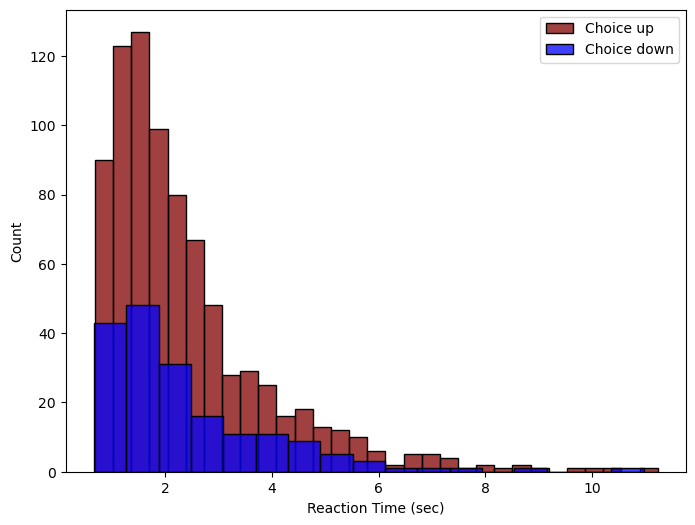

In [24]:
# Plotting the simulated data as a simple histogram
f, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = sns.histplot(dataset.rt[dataset.response == 1], color='maroon')
ax = sns.histplot(dataset.rt[dataset.response == -1], color='blue')

ax.legend(['Choice up', 'Choice down'])
ax.set_xlabel('Reaction Time (sec)')

... you know, the familiar stuff. The simulated data consists of **reaction time** and **choice**.

The `HSSM` class creates a [PyMC](https://www.pymc.io/welcome.html) model, and initialize it when provided the simulated dataset.

In [25]:
simple_ddm = hssm.HSSM(data=dataset)

Model initialized successfully.


Now, let's look at what this model has. Since this is a PyMC model, HSSM allows us to show the model structure both textually and graphically.

In [26]:
simple_ddm

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 20.0)

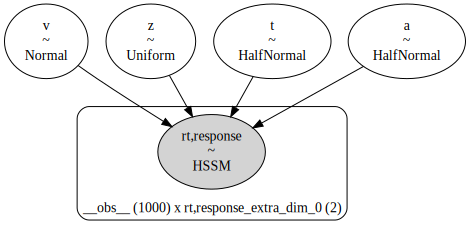

In [27]:
simple_ddm.graph()

A quick note about this diagram: it is called the **plate notation**, used often in probabilistic graphical models. 

* White nodes: **parameters**, these are random variables in the model and we want to estimate them.
* Gray nodes: **observed variables**, are fixed (or conditioned on).
* Rounded rectangles: **the plate**, provide us with information about dimensionality of objects (i.e., number of observations).
* Rectangles with sharp edges: **deterministic, but computed quantities**.

We can show it here because, again, HSSM utilizes a PyMC backbone, which inherits the diagram from GraphViz. For the same reason, we see that HSSM samples from the model in a similar way as PyMC.

In [ ]:
simple_ddm_samples = simple_ddm.sample(
    sampler="mcmc",     # type of sampler to choose
    cores=4,            # how many cores to use
    chains=4,           # how many chains to run
    draws=500,          # number of draws from the markov chain
    tune=500,           # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
    mp_ctx="spawn",
)

Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, t, a, v]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 178 seconds.
100%|██████████| 2000/2000 [00:03<00:00, 649.73it/s]


The sampled parameters are bundled together as an ArViZ `InferenceData` object. We can inspect it by directly calling the variables. To access parts of the posterior samples, we can also extract them as a `NumPy` array.

In [29]:
simple_ddm_samples

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [30]:
simple_ddm_samples.posterior.v.values

array([[0.53722185, 0.5089991 , 0.5089991 , ..., 0.5987197 , 0.5760287 ,
        0.51177615],
       [0.5477842 , 0.5818695 , 0.59189165, ..., 0.60695726, 0.5828904 ,
        0.5136022 ],
       [0.617985  , 0.58729815, 0.5654565 , ..., 0.56313163, 0.5846035 ,
        0.54348105],
       [0.5465156 , 0.597413  , 0.5420499 , ..., 0.51258683, 0.58156765,
        0.59795773]], dtype=float32)

### Diagnostics

Because of the use of the ArViZ `InferenceObject`, we can do all of our diagnostics out of the box from ArViZ as well.

In [31]:
az.summary(simple_ddm_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.493,0.013,0.469,0.518,0.000,0.000,1315.0,1430.0,1.0
v,0.548,0.034,0.485,0.609,0.001,0.001,1277.0,1407.0,1.0
t,0.493,0.020,0.452,0.528,0.001,0.000,1173.0,1305.0,1.0
a,1.467,0.028,1.407,1.513,0.001,0.001,1243.0,1390.0,1.0


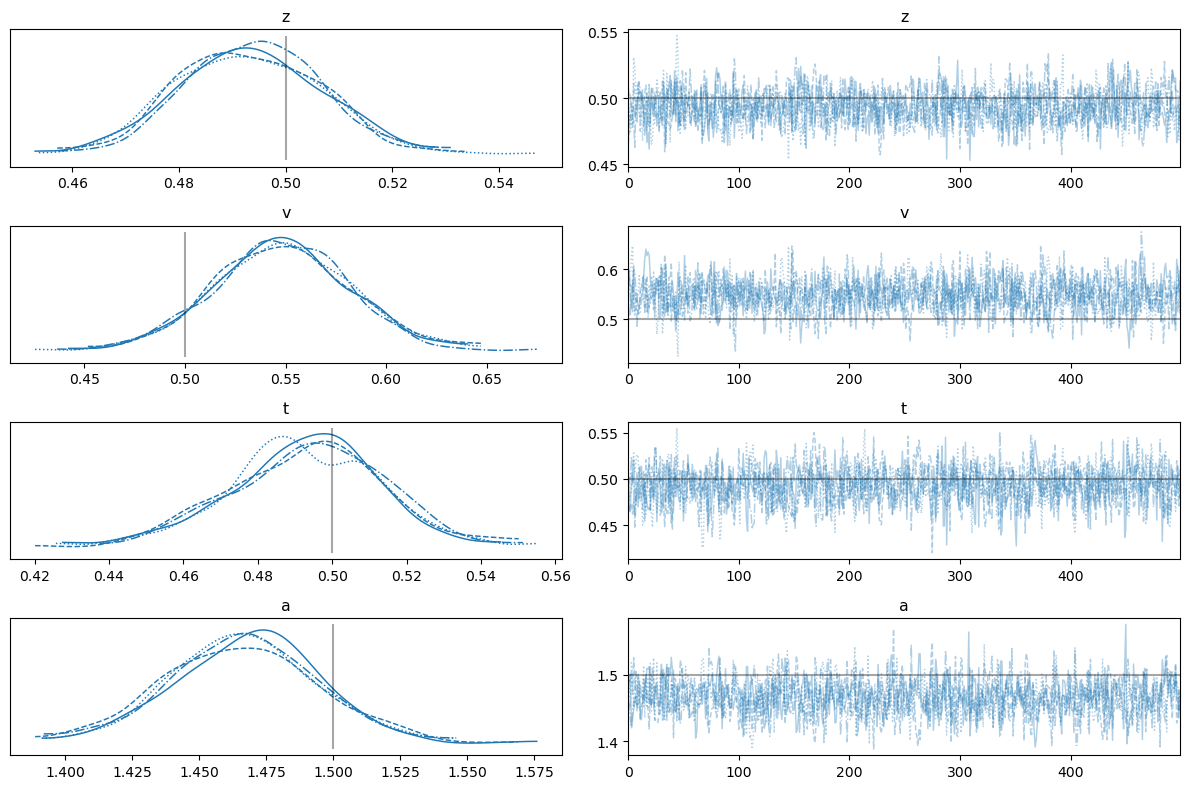

In [32]:
az.plot_trace(simple_ddm_samples, lines=[(key, {}, true_params[key]) for key in true_params],)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

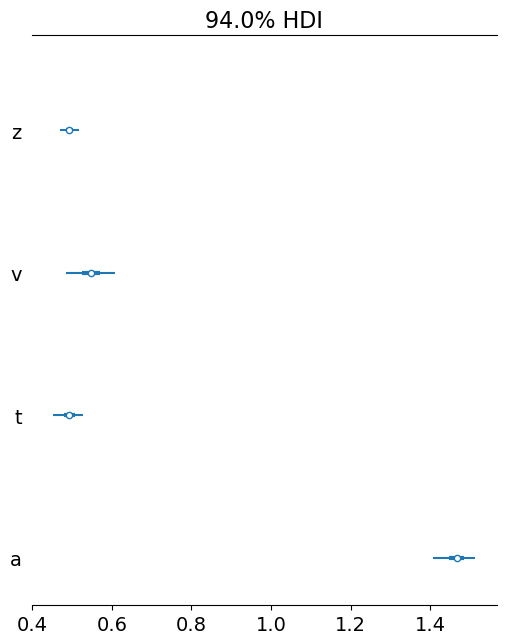

In [33]:
az.plot_forest(simple_ddm.traces, combined=True)

In [35]:
simple_ddm.traces

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

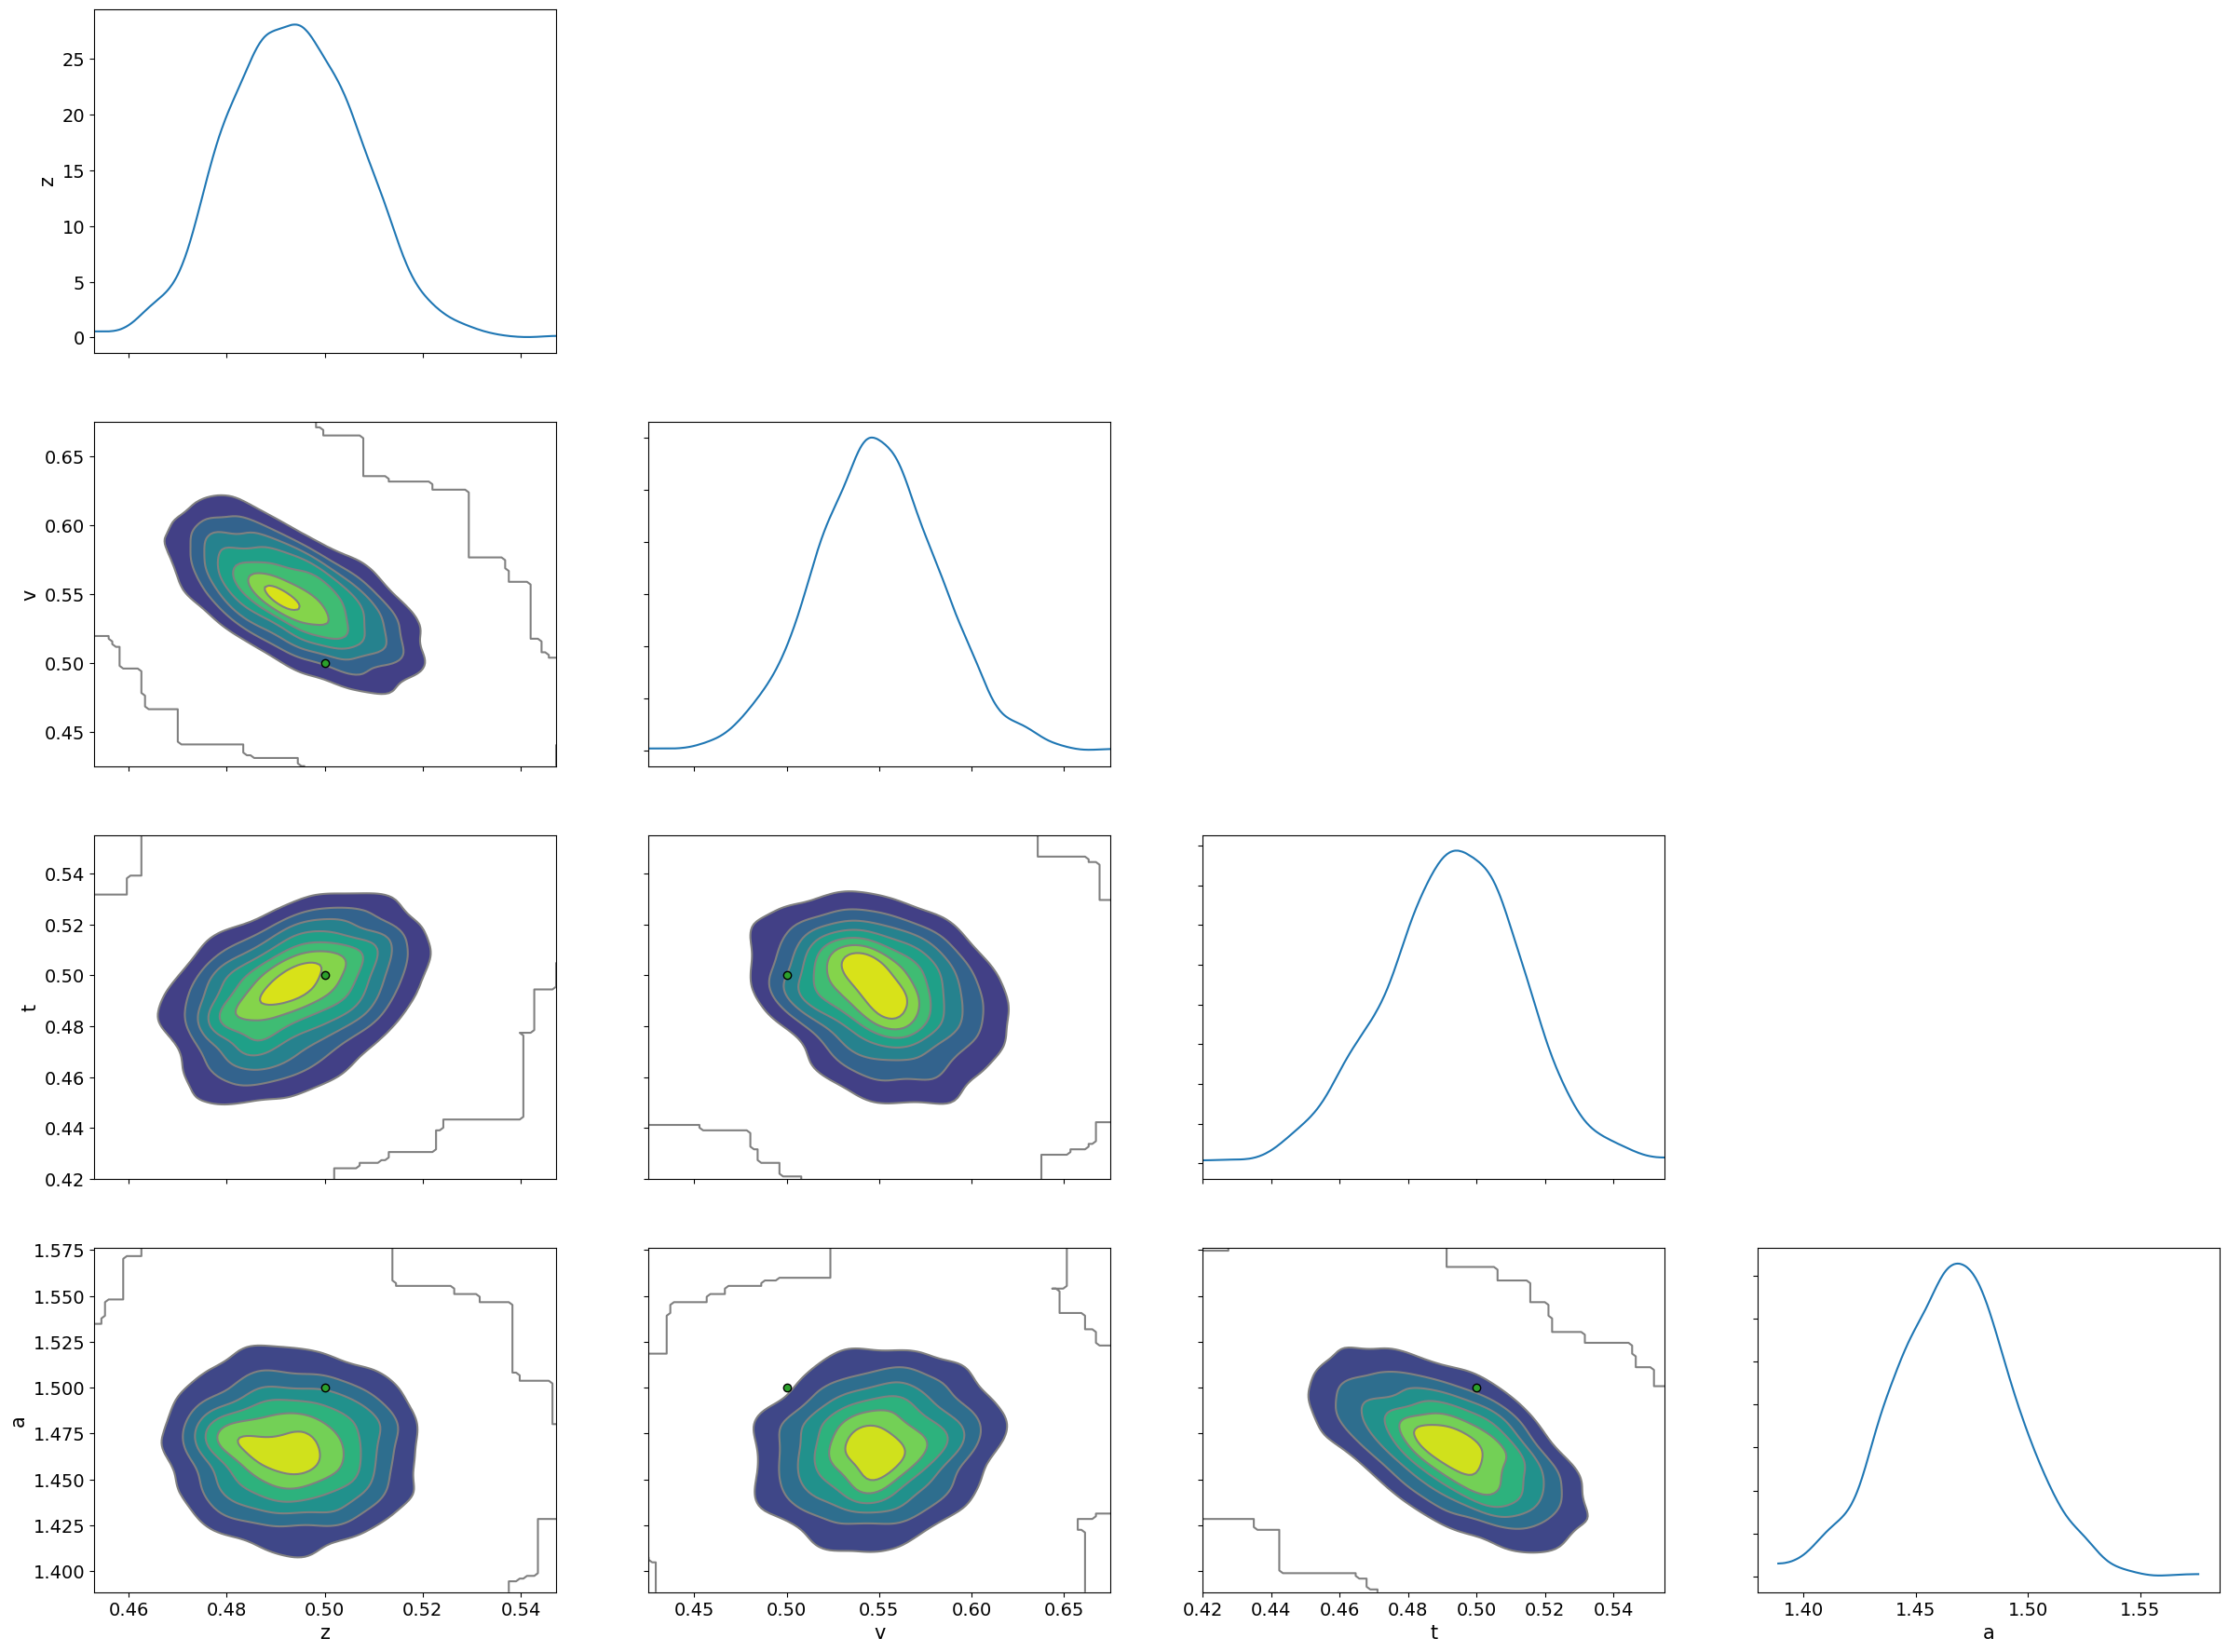

In [38]:
ax = az.plot_pair(
    simple_ddm.traces,
    kind="kde",
    reference_values=true_params,
    marginals=True,
)

## Basic Hierarchical Model

Now that we understand the workflow a bit more, we can start setting up a hierarchical model workflow with HSSM.

In this simple example, we would define a varying drift rate for each participant as

\begin{equation}
    v_i = v_{0, i} + v_{x, i} x + v_{y, i} y,
\end{equation}

\noindent where

* $v_{0, i} \sim \mathcal{N}(\mu_{i}, \sigma_{i})$ is a random intercept
* $x, y$ are base drift rate for each participant
* $v_{x, i}, v_{y, i}$ are random slopes for weighting the base drift rate for each participant 

In [ ]:
def simulate_simple_hddm(
    n_participants : int = 10, 
    n_trials : int = 300,
    drift_mean : float = 0.5,
    drift_sd : float = 0.5,  
    threshold : float = 1.5,
    bias : float = 0.5,
    ndt : float = 1.5
):
    """
    Simulate drift-diffusion process for multiple participants over multiple trials, 
    where the drift rate for each participant is sampled independently.

    Parameters
    ----------
    n_participants  :   int, default: 10
        Number of participants.
    n_trials        :   int, default: 300
        Number of trials.
    drift_mean      :   float, default: 0.5
        Population-level mean of the drift rate.
    drift_sd        :   float, default: 0.5
        Population-level standard deviation of the drift rate.
    threshold       :   float, default: 1.5
        Shared upper boundary for decision-making (a) for each participant.
    bias            :   float, default: 0.5
        Shared initial bias (b) for each participant.
    ndt             :   float, default: 1.5
        Shared non-decision time (tau) for each participant.
    """

    # Initialize dataset
    dataset = []

    for i in range(n_participants):
        
        # Sample random intercept per participant
        v_intercept = RNG.normal(drift_mean, drift_sd, size=1)

        # Coefficients
        v_x = 0.8
        v_y = 0.3

        # Sample random slop per participant per trial
        x = RNG.uniform(-1, 1, size=n_trials)
        y = RNG.uniform(-1, 1, size=n_trials)

        # Sample drift per participant along with other default parameters
        params = {
            'v': v_intercept + v_x * x + v_y * y,
            'a': threshold,
            'z': bias,
            't': ndt
        }

        # Simulate data
        dataset_i = hssm.simulate_data(model='ddm', theta=params, size=1)
        dataset_i['participant'] = i
        dataset_i['x'] = x
        dataset_i['y'] = y

        dataset.append(dataset_i)
    
    # Concatenate dataset for all participants as pd.DataFrame (important for PyMC)
    return pd.concat(dataset)

In [9]:
# Make single dataframe out of participant-wise datasets
simple_hddm_dataset = simulate_simple_hddm(n_participants=6)
print(type(simple_hddm_dataset), simple_hddm_dataset.shape)

<class 'pandas.core.frame.DataFrame'> (1800, 5)


Now we can create the sampling model for the dataset

In [11]:
simple_hddm = hssm.HSSM(
    data=simple_hddm_dataset,
    model="ddm",
    noncentered=True,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Normal",
                    "mu": 0.0,
                    "sigma": 0.5,
                },
                "x": {"name": "Normal", "mu": 0.0, "sigma": 0.5},
                "y": {"name": "Normal", "mu": 0.0, "sigma": 0.5},
            },
            "formula": "v ~ 1 + (1|participant) + x + y",
            "link": "identity",
        }
    ],
)

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.


Model initialized successfully.


Let's visualize the model.

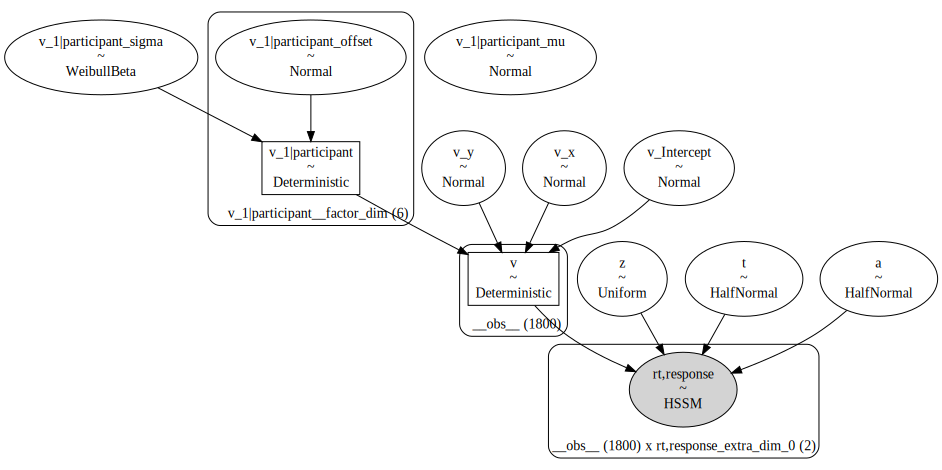

In [14]:
simple_hddm.graph()

In [15]:
hierarchical_samples = simple_hddm.sample(
    sampler="mcmc",
    chains=4,
    cores=4,
    draws=500,
    tune=500, # In practice, it is better to have more burn-in samples
    mp_ctx="spawn",
)

Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, z, a, v_Intercept, v_x, v_y, v_1|participant_mu, v_1|participant_sigma, v_1|participant_offset]


Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 546 seconds.
100%|██████████| 2000/2000 [00:05<00:00, 380.04it/s]


### Diagnostics

The diagnostics workflow is the same as before. But this time, you can see that the participants are considered differently.

In [16]:
az.summary(hierarchical_samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_1|participant_sigma,0.578,0.128,0.347,0.817,0.005,0.003,744.0,826.0,1.00
v_y,0.301,0.035,0.235,0.367,0.001,0.001,2018.0,1290.0,1.00
v_1|participant_mu,-0.001,0.260,-0.514,0.448,0.005,0.006,2694.0,1495.0,1.01
v_1|participant[0],-1.134,0.226,-1.529,-0.690,0.010,0.007,491.0,784.0,1.01
v_1|participant[1],0.309,0.228,-0.115,0.718,0.010,0.007,492.0,802.0,1.01
v_1|participant[2],0.772,0.229,0.377,1.230,0.010,0.007,515.0,753.0,1.01
v_1|participant[3],0.368,0.227,-0.026,0.810,0.010,0.007,481.0,815.0,1.01
v_1|participant[4],0.416,0.225,-0.004,0.832,0.011,0.008,450.0,778.0,1.01
v_1|participant[5],-0.116,0.226,-0.542,0.288,0.010,0.007,490.0,829.0,1.01
v_1|participant_offset[0],-2.068,0.623,-3.235,-0.907,0.025,0.018,607.0,859.0,1.01


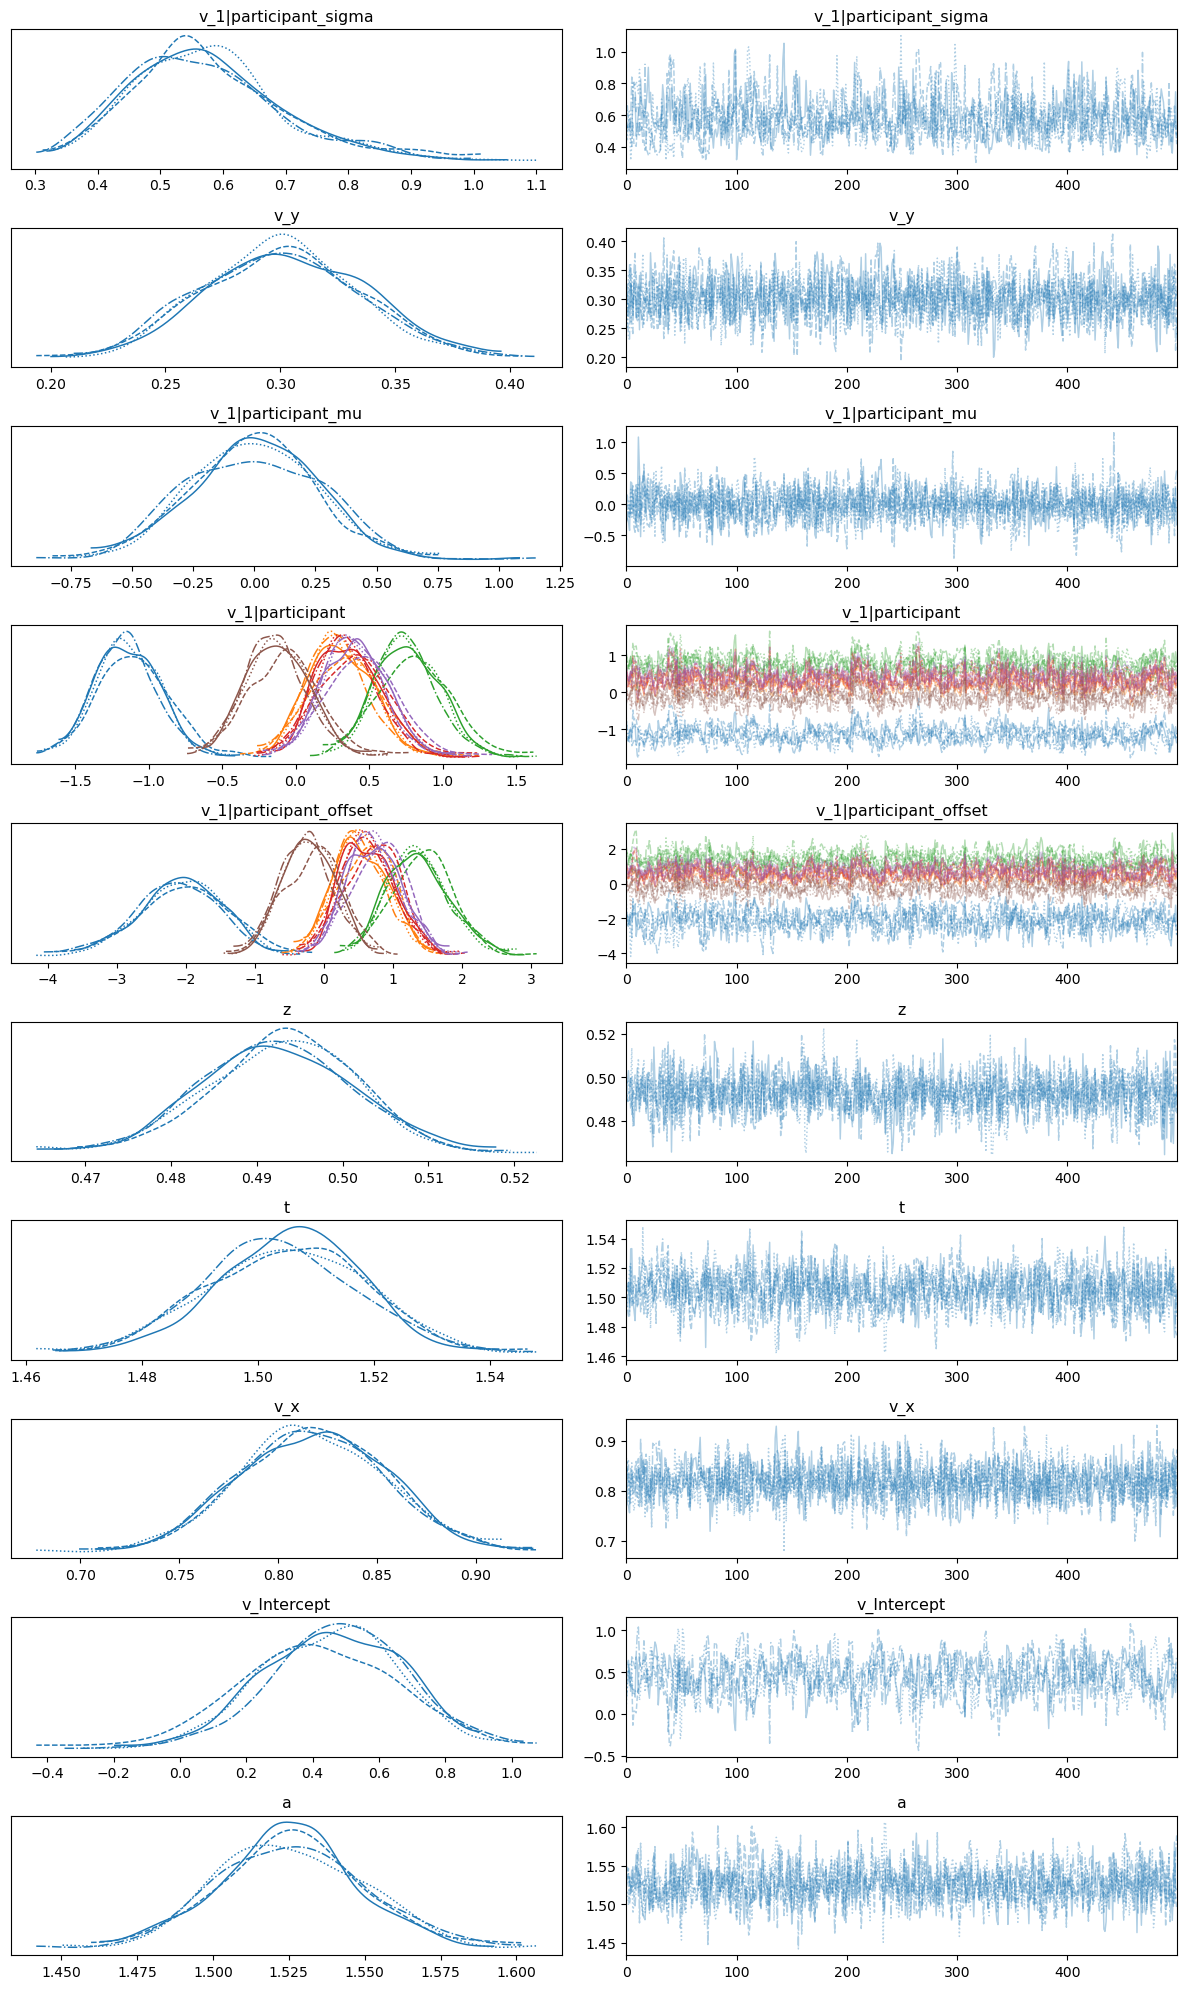

In [17]:
az.plot_trace(hierarchical_samples)
plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

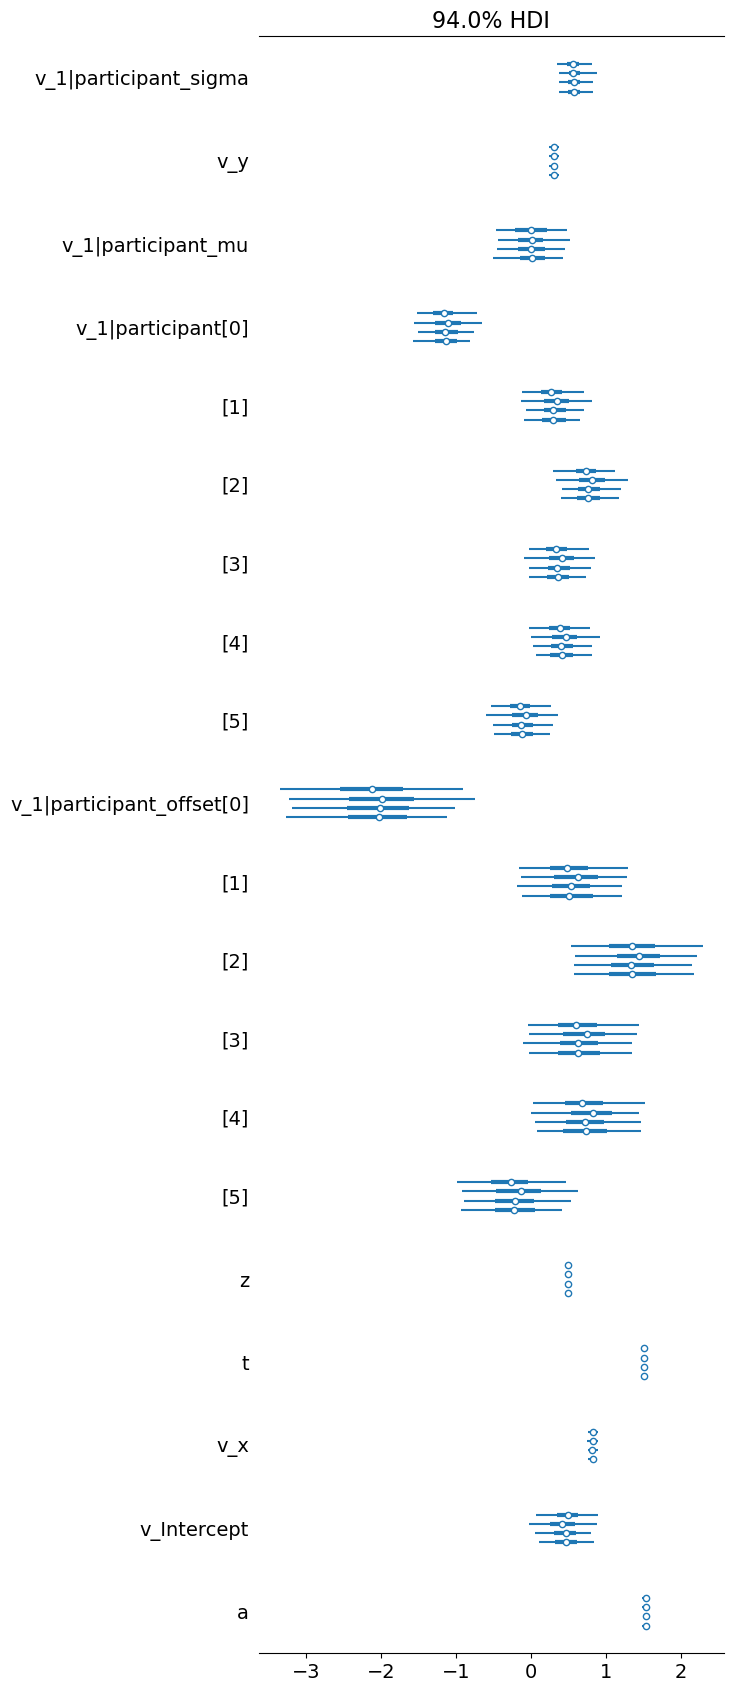

In [19]:
# 4 forest plots per variable, one per chain
az.plot_forest(hierarchical_samples)

## Exercise: Modeling a DDM Variant with Collapsing Bounds

![alt text](collapsing-bounds.png)

In some instances of perceptual decision-making (i.e., when an urgency signal is present), we model the process as a DDM with **collapsing bounds** [(Hawkins et al., 2015)](https://www.jneurosci.org/content/35/6/2476.short). HSSM contains many supported model variants, and the collapsing bounds models are represented by an extra parameter $\theta$, which represents the slope of the bounds that collapse to the center.

In [20]:
# Aside: you can find a list of all supported models in HSSM using the following line of code:
hssm.defaults.SupportedModels
# We would choose the 'angle' model for our collapsing-bounds DDM.

typing.Literal['ddm', 'ddm_sdv', 'full_ddm', 'angle', 'levy', 'ornstein', 'weibull', 'race_no_bias_angle_4', 'ddm_seq2_no_bias', 'lba3', 'lba2']

In [ ]:
collapsing_bounds_params = true_params

# Add an extra angle parameter
### Our code here

In [ ]:
# Simulate data for the collapsing-bounds DDM. 
# You can also make this simulation hierarchical by varying the angles for each participant.
### Our code here

In [ ]:
# Create a model for the collapsing-bounds DDM, and visualize the model graphically
### Our code here

In [ ]:
# Sample from the model
### Our code here

In [21]:
# Diagnostics with ArViZ
### Our code here

That's it! You now know the basic workflow of the HSSM toolbox.